# FIA-MS data processing and visualization

## Import dependencies and read in the data

- Requires py v3.9 due to PyOpenMS dependencies
- Requires custom installation of BFAIR (see https://github.com/AutoFlowResearch/BFAIR for instructions on installation)

In [1]:
# General py packages
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

# BFAIR py package
import BFAIR.FIA_MS as fia_ms
import BFAIR.normalization as normalization

Define functions and other shared sub-routines not yet integrated into the BFAIR modules

In [6]:
def removeConstFeatures(metabolites, intensities):
    """
    Remove singular or constant features
    
    Parameters
    ----------
    metabolites : list
        list of unique metabolites
    intensities : pandas.DataFrame
        the extracted intensities
    
    Returns
    -------
    intensities : pandas.DataFrame
        the filtered metabolites
    """
    for i, metabolite in enumerate(metabolites):
        row = intensities[intensities["Metabolite"] == metabolite]
        # filter out single- or constant-value features
        if len(row) == 1 or np.std(row["Intensity"]) == 0:
            index = intensities.index[intensities["Metabolite"] == metabolite].tolist()
            intensities = intensities.drop(labels= index, axis = 0)
    return intensities

def removeNAFeatures(metabolites, intensities):
    """
    Remove features with more than 50% NAs
    
    Parameters
    ----------
    metabolites : list
        list of unique metabolites
    intensities : pandas.DataFrame
        the extracted intensities; modified in place
    
    Returns
    -------
    intensities : pandas.DataFrame
        the filtered metabolites
    """
    intensities_filtered_pivot = intensities.pivot(index="sample_group_name", columns="Metabolite", values="Intensity")
    for i, metabolite in enumerate(metabolites):
        if intensities_filtered_pivot[metabolite].isna().sum() / intensities_filtered_pivot.shape[0] > 0.5:
            index = intensities.index[intensities["Metabolite"] == metabolite].tolist()
            intensities = intensities.drop(labels= index, axis = 0)
    return intensities

def nonParametricRSD(intensities, threshold=0.3):
    """
    Determine the ratio of features in QC samples that
    have a non-parametric %RSD <= threshold
    
    Parameters
    ----------
    intensities : pandas.DataFrame
        the extracted intensities; modified in place
    threshold: float
        the threshold to use
    
    Returns
    -------
    stats_qc_df: pandas.DataFrame
        dataframe with columns for metabolites and the
        Mean, Var, RSD, and np_RSD of each metabolite
    ratio_np_RSD: float
        the ratio of features below the threshold
    ratio_RSD: float
        the ratio of features below the threshold
    """
    stats_qc_dict = {}

    for met in intensities["Metabolite"].unique():
        intensities_met = intensities[intensities["Metabolite"] == met]
        
        mean = np.mean(intensities_met["Intensity"])
        var = np.var(intensities_met["Intensity"])
        rsd = np.sqrt(var) / mean
        
        median = np.median(intensities_met["Intensity"])
        mad = np.median(np.absolute(intensities_met["Intensity"] - median))
        np_rsd = (1.4826 * mad) / median
        
        stats_qc_dict[met] = {"Mean" : mean,
                            "Var" : var,
                            "RSD" : rsd,
                            "np_RSD" : np_rsd}

    stats_qc_df = pd.DataFrame.from_dict(stats_qc_dict, "index")
    ratio_np_RSD = stats_qc_df[stats_qc_df["np_RSD"] <= threshold].shape[0] / stats_qc_df.shape[0]
    ratio_RSD = stats_qc_df[stats_qc_df["RSD"] <= threshold].shape[0] / stats_qc_df.shape[0]
    return stats_qc_df, ratio_np_RSD, ratio_RSD

def nonParametricDispersionRatio(intensities, intensities_QCs, threshold=0.5):
    """
    Determine the dispersion ratio of QC samples that
    have a non-parametric ratio <= threshold
    
    Parameters
    ----------
    intensities : pandas.DataFrame
        the extracted intensities;
    intensities_QCs : pandas.DataFrame
        the extracted intensities of only the QCs
    threshold: float
        the threshold to use
    
    Returns
    -------
    stats_qc: pandas.DataFrame
        dataframe with columns for metabolites and the
        dispersion ratio of each metabolite
    ratio_np: float
        the ratio of features below the threshold for
        the non parametric version
    ratio_p: float
        the ratio of features below the threshold for
        the parametric version
    """
    ratio_dict = {}

    for met in intensities["Metabolite"].unique():
        
        intensities_QC_met = intensities_QCs[intensities_QCs["Metabolite"] == met]
        median_qc = np.median(intensities_QC_met["Intensity"])
        mad_qc = np.median(np.absolute(intensities_QC_met["Intensity"] - median_qc))
        sd_qc = np.std(intensities_QC_met["Intensity"])
        
        intensities_met = intensities[intensities["Metabolite"] == met]
        median = np.median(intensities_met["Intensity"])
        mad = np.median(np.absolute(intensities_met["Intensity"] - median))
        sd = np.std(intensities_met["Intensity"])
        
        ratio_np = mad_qc / mad
        ratio_p = sd_qc / sd

        ratio_dict[met] = {"dispersion_ratio_np" : ratio_np,
            "dispersion_ratio_p" : ratio_p}

    dispersion_ratio_df = pd.DataFrame.from_dict(ratio_dict, "index")
    dispersion_ratio_np = dispersion_ratio_df[dispersion_ratio_df["dispersion_ratio_np"] <= threshold].shape[0] / dispersion_ratio_df.shape[0]
    dispersion_ratio_p = dispersion_ratio_df[dispersion_ratio_df["dispersion_ratio_p"] <= threshold].shape[0] / dispersion_ratio_df.shape[0]
    return dispersion_ratio_df, dispersion_ratio_np, dispersion_ratio_p

Set the directories

In [99]:
work_dir = "C:/Users/dmccl/Downloads"
batch_name = "MetEngDemo"
run_name = "Orbitrap1"

if run_name == "Bruker":
    feature_dir = "Z:/Douglas/AutoFlow data/AFS Experiments/AFS-43-103_FIA-MS_MetEng-NP/features_Bruker"
    sequence_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/MetEng-NP-01_ScimaX"
    database_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/CHEMISTRY"
    if batch_name == "MetEngDemo":
        database_file = "/yeastGEM-Tab-Str_struct.tsv"
        sequence_file = "/sequence_SCerevisiae.csv"
        intensities_file = "/MetEngDemo_Bruker_Intensities.csv"
        MeanVarRSD_file = "/MetEngDemo_Bruker_MeanVarRSD.csv"
    else:
        database_file = "/streptomyces-endo-exo_struct.tsv"
        sequence_file = "/sequence_Strep.csv"
        intensities_file = "/NPDemo_Bruker_Intensities.csv"
        MeanVarRSD_file = "/NPDemo_Bruker_MeanVarRSD.csv"
elif run_name == "Orbitrap1":
    feature_dir = "Z:/Douglas/AutoFlow data/AFS Experiments/AFS-43-103_FIA-MS_MetEng-NP/features_DTU"
    sequence_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/MetEng-NP-01_Orbitrap"
    database_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/CHEMISTRY"
    if batch_name == "MetEngDemo":
        database_file = "/yeastGEM-Tab-Str_struct.tsv"
        sequence_file = "/sequence_SCerevisiae.csv"
        intensities_file = "/MetEngDemo_Orbitrap1_Intensities.csv"
        MeanVarRSD_file = "/MetEngDemo_Orbitrap1_MeanVarRSD.csv"
    else:
        database_file = "/streptomyces-endo-exo_struct.tsv"
        sequence_file = "/sequence_Strep.csv"
        intensities_file = "/NPDemo_Orbitrap1_Intensities.csv"
        MeanVarRSD_file = "/NPDemo_Orbitrap1_MeanVarRSD.csv"
elif run_name == "Orbitrap2":
    feature_dir = "Z:/Douglas/AutoFlow data/AFS Experiments/AFS-43-103_FIA-MS_MetEng-NP/features_round2"
    sequence_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/MetEng-NP-02_Orbitrap"
    database_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/CHEMISTRY"
    if batch_name == "MetEngDemo":
        database_file = "/yeastGEM-Tab-Str_struct.tsv"
        sequence_file = "/sequence_SCerevisiae.csv"
        intensities_file = "/MetEngDemo_Orbitrap1_Intensities.csv"
        MeanVarRSD_file = "/MetEngDemo_Orbitrap1_MeanVarRSD.csv"
    else:
        database_file = "/streptomyces-endo-exo_struct.tsv"
        sequence_file = "/sequence_Strep.csv"
        intensities_file = "/NPDemo_Orbitrap1_Intensities.csv"
        MeanVarRSD_file = "/NPDemo_Orbitrap1_MeanVarRSD.csv"

Read in the sequence and remove blank rows

<AxesSubplot:xlabel='sample_name'>

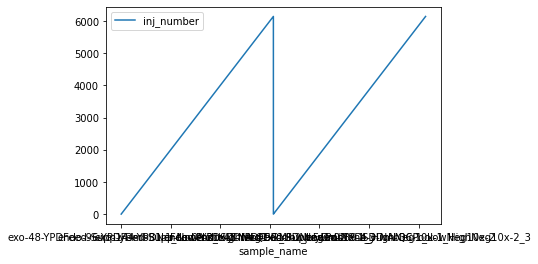

In [100]:
sequence = pd.read_csv(sequence_dir + sequence_file, sep=",")
sequence = sequence[sequence["sample_name"].str.contains("BLANK") == False]

# Quick QC of the data
sequence.plot(x="sample_name", y="inj_number", kind="line")

Read in the database file

In [101]:
database = pd.read_csv(database_dir + database_file, sep="\t", header=None)
database = database.drop(database[database.iloc[:,0].str.contains("EXTRA")].index)

Extract all the relevant information from the provided .featureXML files

In [102]:
# Read in the intensities for .FeatureXML
intensities = fia_ms.extractNamesAndIntensities(feature_dir, sequence["sample_group_name"].unique(), database)

# Remove "HMDB:" from metabolite IDs
#intensities["Metabolite"] = intensities["Metabolite"].str.replace("HMDB:", "")

# Export to csv
intensities.to_csv(work_dir + intensities_file)

# Quick QC of the data
#intensities_selected = intensities[intensities["Metabolite"] == "8__hydroxygeraniol"]
intensities_selected = intensities[intensities["Metabolite"] == "glu_D[c]"]
intensities_selected.plot(x="sample_group_name", y="Intensity", kind="line")

## Data filtering, normalization, quality control (QC), and basic statistical analysis

Data filtering #1: remove single and constant value features

In [ ]:
metabolites = intensities["Metabolite"].unique()

intensities_filtered = removeConstFeatures(metabolites, intensities)
print("Intensities ", intensities.shape[0])
print("Intensities filtered ", intensities_filtered.shape[0])
print("Intensities difference ", intensities.shape[0] - intensities_filtered.shape[0])

Intensities  112916
Intensities filtered  112916
Intensities difference  0


Date filtering #2: remove features with more than 50% NAs

In [ ]:
metabolites = intensities_filtered["Metabolite"].unique()

intensities_filtered = removeNAFeatures(metabolites, intensities_filtered)
print("Percent filtered ", 100 * (1 - (intensities_filtered.shape[0]/intensities.shape[0])))

Percent filtered  22.561904424527967


Data QC #1: non-parametric %RSD

In [ ]:
intensities_QC = intensities_filtered[intensities_filtered["sample_group_name"].str.contains("QC")]

stats_qc_df, ratio_np_RSD, ratio_RSD = nonParametricRSD(intensities_QC)
print("Percent QC features with NP RSD <= 0.3 ", ratio_np_RSD)
print("Percent QC features with RSD <= 0.3 ", ratio_RSD)

Percent QC features with NP RSD <= 0.3  0.04262295081967213
Percent QC features with RSD <= 0.3  0.013114754098360656


Data QC #2: non-parametric dispersion ratio

In [ ]:
intensities_QC = intensities_filtered[intensities_filtered["sample_group_name"].str.contains("QC")]

dispersion_ratio_df, dispersion_ratio_np, dispersion_ratio_p = nonParametricDispersionRatio(intensities_filtered, intensities_QC)
print("Percent non parametric dispersion ratio <= 0.5 ", dispersion_ratio_np)
print("Percent parametric dispersion ratio <= 0.5 ", dispersion_ratio_p)

Percent non parametric dispersion ratio <= 0.5  0.06557377049180328
Percent parametric dispersion ratio <= 0.5  0.28524590163934427


Data normalize #1: Total sum intensity (tsi) sample normalization and log transformation

array([[<AxesSubplot:title={'center':'Intensity'}>]], dtype=object)

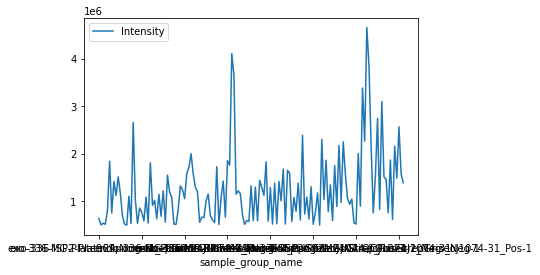

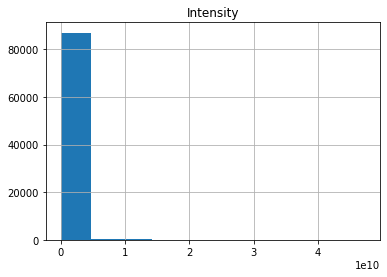

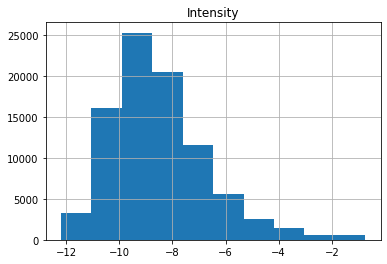

In [ ]:
intensities_tsi = normalization.tsi_norm(intensities_filtered)
intensities_tsi["Intensity"] = np.log(intensities_tsi["Intensity"])

#intensities_selected = intensities[intensities["Metabolite"] == "8__hydroxygeraniol"]
intensities_selected = intensities[intensities["Metabolite"] == "glu_D[c]"]
intensities_selected.plot(x="sample_group_name", y="Intensity", kind="line")
intensities_filtered.hist("Intensity")
intensities_tsi.hist("Intensity")

Data QC #3: parametric %RSD

In [ ]:
normalized_intensities_QC = intensities_tsi[intensities_tsi["sample_group_name"].str.contains("QC")]
stats_qc_df, ratio_np_RSD, ratio_RSD = nonParametricRSD(normalized_intensities_QC)
print("Percent QC features with NP RSD <= 0.3 ", ratio_np_RSD)
print("Percent QC features with RSD <= 0.3 ", ratio_RSD)

Percent QC features with NP RSD <= 0.3  1.0
Percent QC features with RSD <= 0.3  1.0


Data QC #4: parametric dispersion ratio

In [ ]:
normalized_intensities_QC = intensities_tsi[intensities_tsi["sample_group_name"].str.contains("QC")]
dispersion_ratio_df, dispersion_ratio_np, dispersion_ratio_p = nonParametricDispersionRatio(intensities_tsi, normalized_intensities_QC)
print("Percent non parametric dispersion ratio <= 0.5 ", dispersion_ratio_np)
print("Percent parametric dispersion ratio <= 0.5 ", dispersion_ratio_p)


Percent non parametric dispersion ratio <= 0.5  0.20655737704918034
Percent parametric dispersion ratio <= 0.5  0.13114754098360656


Data filtering #3: remove high variable features (QC > 30% RSD)

In [ ]:
to_discard = stats_qc_df[np.abs(stats_qc_df["RSD"]) > 0.3]
to_discard.index.name = 'Metabolite'
to_discard.reset_index(inplace=True)
intensities_tsi_filt = intensities_tsi[~intensities_tsi["Metabolite"].isin(to_discard["Metabolite"])]

print("Intensities ", intensities_tsi.shape[0])
print("Intensities filtered ", intensities_tsi_filt.shape[0])
print("Intensities difference ", intensities_tsi.shape[0] - intensities_tsi_filt.shape[0])

Intensities  87440
Intensities filtered  86759
Intensities difference  681


Data filtering #4: remove samples without the minimum number of replicates and highly variable features (> 50% RSD)

In [ ]:
%%capture
intensities_stats = fia_ms.calculateMeanVarRSD(intensities_tsi_filt, sequence.drop_duplicates(["sample_group_name", "replicate_group_name"]), min_reps=2)

# Export to csv
intensities_stats.to_csv(work_dir + MeanVarRSD_file)

In [ ]:
# Filter metabolites
to_discard = intensities_stats[np.abs(intensities_stats["RSD"]) > 0.5]
to_discard_mets = to_discard["Metabolite"].unique()

# Filter sample_group_names
to_keep_injections = sequence[sequence["replicate_group_name"].isin(intensities_stats["replicate_group_name"])]

intensities_tsi_filt2 = intensities_tsi_filt[~intensities_tsi_filt["Metabolite"].isin(to_discard_mets) & intensities_tsi_filt["sample_group_name"].isin(to_keep_injections["sample_group_name"].unique())]
print("n discarded metabolites", len(to_discard_mets))
print("Intensities ", intensities_tsi_filt.shape[0])
print("Intensities filtered ", intensities_tsi_filt2.shape[0])
print("Intensities difference ", intensities_tsi_filt.shape[0] - intensities_tsi_filt2.shape[0])

n discarded metabolites 2
Intensities  86759
Intensities filtered  86101
Intensities difference  658


Data QC #5: Visualization of the mean and RSD

Text(0.5, 1.0, 'Mean')

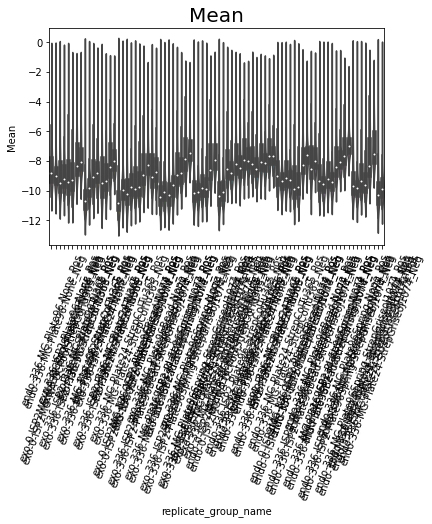

In [ ]:
#intensities_selected = intensities_stats[intensities_stats["Metabolite"] == "8__hydroxygeraniol"]

sns.violinplot(x="replicate_group_name", y="Mean", data=intensities_stats, orient = 'v')
plt.xticks(rotation=70)
plt.title('Mean', size = 20)

Text(0.5, 1.0, 'RSD')

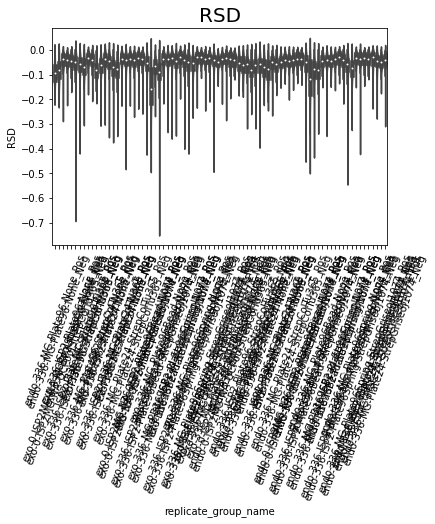

In [ ]:
sns.violinplot(x="replicate_group_name", y="RSD", data=intensities_stats, orient = 'v')
plt.xticks(rotation=70)
plt.title('RSD', size = 20)

Data QC #5: PCA of replicates, blanks, and QCs

In [82]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [93]:
# Split into smaller subsets by batch, polarity, compartment, etc.
batch_name = ["MetEngDemo","NPDemo"]
scan_polarity = ["positive","negative"]
sample_type = ["Blank","QC","Unknown"]
cellular_location = ["exo-", "endo-"]

time_point = ["48","96","144"]
media_type = ["MG","ISP2"]

time_point = ["0","336","144"]
plate_type = ["Plate96","Plate96Bead","Plate96Spring","Plate24","Plate24Bead","Plate24Spring"]
cell_type = ["StrepColTu365", "StrepGriseoJ1074"]


# Define the sequence subsets using the pattern batch_name/scan_polarity/sample_type/cellular_location
sequence_MetEngDemo_Pos_Unknown_endo = sequence[sequence["batch_name"].str.contains("MetEngDemo") 
    & sequence["scan_polarity"].str.contains("positive") 
    & sequence["sample_type"].str.contains("Unknown")
    & sequence["replicate_group_name"].str.contains("endo-")
    & sequence["replicate_group_name"].str.contains("48-")
    ]
sequence_MetEngDemo_Pos_Unknown_exo = sequence[sequence["batch_name"].str.contains("MetEngDemo") 
    & sequence["scan_polarity"].str.contains("positive") 
    & sequence["sample_type"].str.contains("Unknown")
    & sequence["replicate_group_name"].str.contains("exo-")
    & sequence["replicate_group_name"].str.contains("48-")
    ]
sequence_NPDemo_Pos_Unknown_exo = sequence[sequence["batch_name"].str.contains("NPDemo") 
    & sequence["scan_polarity"].str.contains("positive") 
    & sequence["sample_type"].str.contains("Unknown")
    #& sequence["replicate_group_name"].str.contains("exo-")
    #& sequence["replicate_group_name"].str.contains("48-")
    ]

# Create the subset and pivot table
intensities_subset = intensities_tsi_filt2[intensities_tsi_filt2["sample_group_name"].isin(sequence_NPDemo_Pos_Unknown_exo["sample_group_name"].unique())]
intensities_piv = intensities_subset.pivot("sample_group_name", "Metabolite", "Intensity")
intensities_piv = intensities_piv.fillna(0)

In [94]:
# min/max scale the data
scaler = MinMaxScaler()
intensities_piv_scaled = scaler.fit_transform(intensities_piv)

# pca
pca = PCA(n_components = 10)
comps = pca.fit_transform(intensities_piv_scaled)

[0.21869515 0.04704855 0.03406492 0.02990591 0.02429752 0.02300275
 0.02255087 0.02165055 0.02138616 0.01999932]


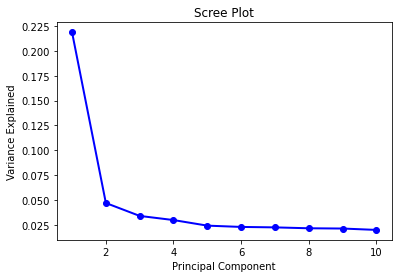

In [95]:
# Scree plot
print(pca.explained_variance_ratio_)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

C:\Users\dmccl\AppData\Local\Temp\ipykernel_8588\1524471019.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot["replicate_group_name"].iloc[i] = sequence["replicate_group_name"][index[0]]
C:\Users\dmccl\AppData\Local\Temp\ipykernel_8588\1524471019.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot["color"].iloc[i] = "#000000"
C:\Users\dmccl\AppData\Local\Temp\ipykernel_8588\1524471019.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

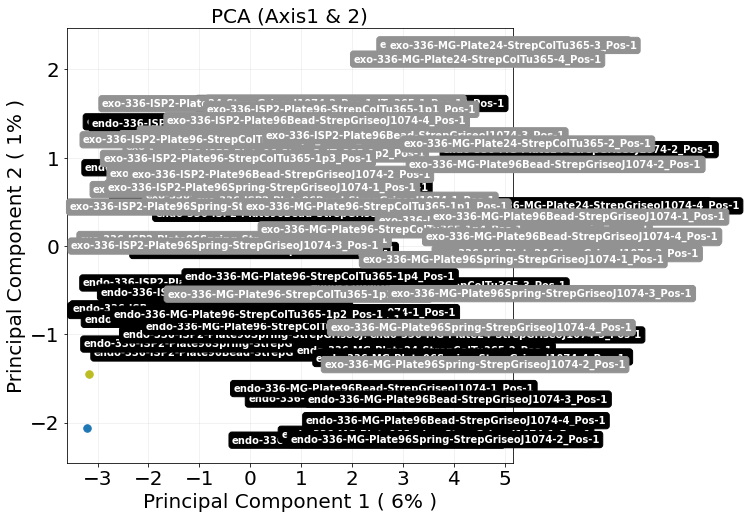

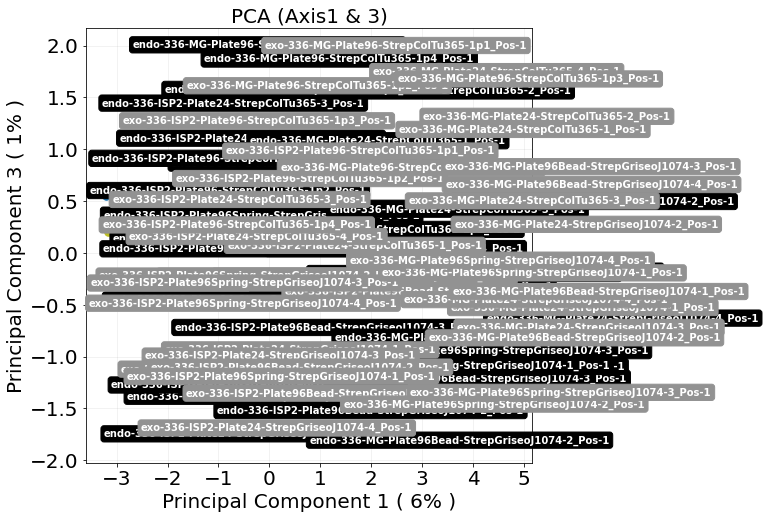

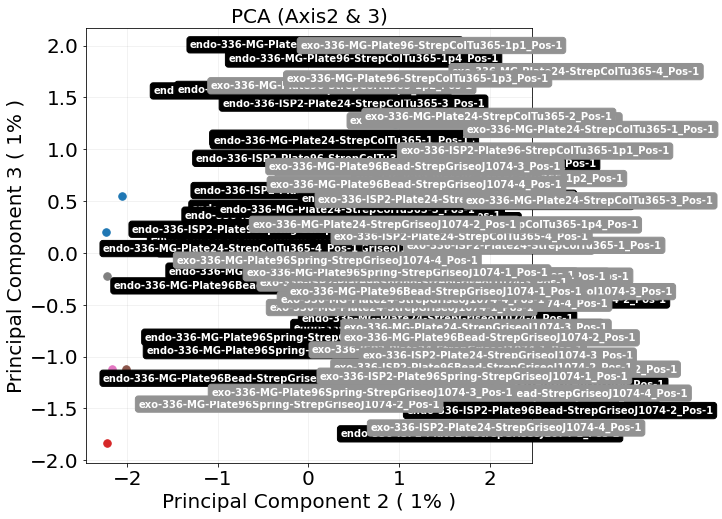

In [97]:
# plot the scores
data_plot = pd.DataFrame(data = comps, columns =  ['pca1', 'pca2',
    'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10'])

# add in the sample_group_names as the labels
labels = intensities_piv.index
data_plot["sample_group_names"] = labels

# add in the replicate_group_name to define the colors
data_plot["replicate_group_name"] = ""
for i,row in data_plot.iterrows():
    index = np.where(sequence["sample_group_name"] == row["sample_group_names"])[0]
    data_plot["replicate_group_name"].iloc[i] = sequence["replicate_group_name"][index[0]]

# define the colors based on the replicate_group_names
data_plot["color"] = ""
for i,row in data_plot.iterrows():
    # add colors
    if row["replicate_group_name"] == "exo-0-YPDSD-NA-QCPool_Pos":
        data_plot["color"].iloc[i] = "#000000"
    elif "endo" in row["replicate_group_name"]:
        data_plot["color"].iloc[i] = "#000000"
    elif "48" in row["replicate_group_name"]:
        data_plot["color"].iloc[i] = "#000000"
    elif row["replicate_group_name"] == "exo-0-YPDSD-NA-QCPool_Neg":
        data_plot["color"].iloc[i] = "#929292"
    elif "exo" in row["replicate_group_name"]:
        data_plot["color"].iloc[i] = "#929292"
    elif "144" in row["replicate_group_name"]:
        data_plot["color"].iloc[i] = "#929292"
    elif row["replicate_group_name"] == "exo-144-YPDFeed-Supp-yDmb31_Pos":
        data_plot["color"].iloc[i] = "#0037ea"
    elif row["replicate_group_name"] == "exo-144-YPDFeed-Supp-yDmb31_Neg":
        data_plot["color"].iloc[i] = "#00b5ff"
    else:
        data_plot["color"].iloc[i] = "#feb24c"

# Make the PCA plot with loadings plot and scree plot for axes 1 to 3
for j in range(1,4):
    for k in range(j+1,4):

        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('Principal Component ' + str(j) + ' ( ' + str(round(pca.explained_variance_[j-1])) + '% )' , fontsize = 20)
        ax.set_ylabel('Principal Component ' + str(k) + ' ( ' + str(round(pca.explained_variance_[k-1])) + '% )' , fontsize = 20)
        ax.set_title('PCA (Axis' + str(j) + ' & ' + str(k) + ')', fontsize = 20)

        plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.1)
        plt.xticks(size = 20)
        #plt.xlabel(size = 20)
        plt.yticks(size = 20)
        #plt.ylabel(size = 20)

        for i, label in enumerate(data_plot["sample_group_names"]):
            x, y = data_plot["pca" + str(j)][i], data_plot["pca" + str(k)][i]
            ax.plot(x, y, ".", markersize=15, label=label)
            
            ax.annotate(data_plot["sample_group_names"][i], (x - 0.5 , y), weight='bold',
                        color='white',
                        bbox=dict(boxstyle="round",
                        facecolor=data_plot["color"][i], edgecolor=data_plot["color"][i],
                       )
                       )

Data QC #6: Check technical replicate correlation (R > 0.9)

In [ ]:
# todo

## Statistical and pathway analyses

Hierarchical clustering analysis without pre-processing

C:\Users\dmccl\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


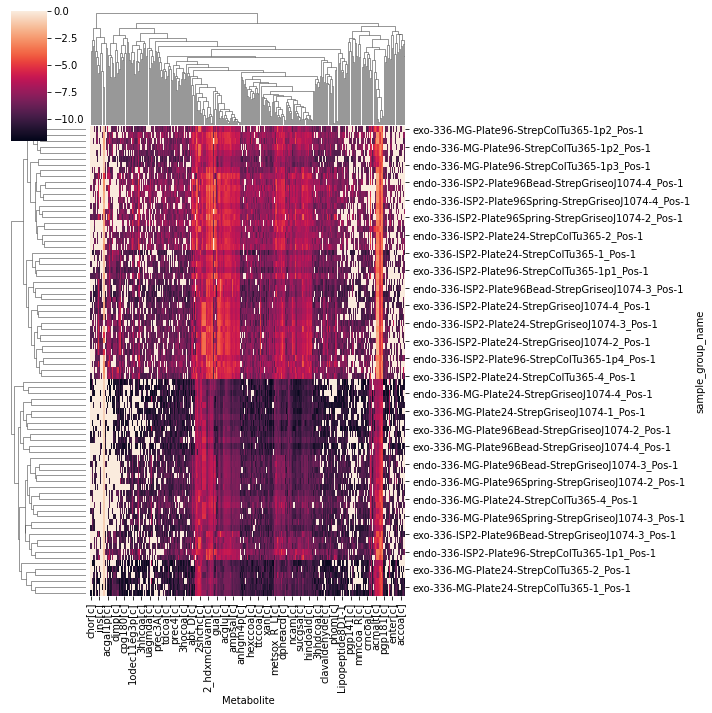

In [98]:
g = sns.clustermap(intensities_piv, method="complete", metric="euclidean")

Clustering analysis with pre-processing using PCA

In [37]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score

In [ ]:
# todo
# Pre-process using PCA

In [38]:
clustering = AgglomerativeClustering(n_clusters=3, linkage="ward") #KMeans
Y_preds = clustering.fit_predict(intensities_piv)

In [ ]:
def plot_actual_prediction(X, Y, Y_preds):
    with plt.style.context(("ggplot", "seaborn")):
        plt.figure(figsize=(17,6))

        plt.subplot(1,2,1)
        plt.scatter(X[Y==0,0],X[Y==0,1], c = 'red', marker="^", s=50)
        plt.scatter(X[Y==1,0],X[Y==1,1], c = 'green', marker="^", s=50)
        plt.scatter(X[Y==2,0],X[Y==2,1], c = 'blue', marker="^", s=50)
        plt.title("Original Data")

        plt.subplot(1,2,2)
        plt.scatter(X[Y_preds==0,0],X[Y_preds==0,1], c = 'red', marker="^", s=50)
        plt.scatter(X[Y_preds==1,0],X[Y_preds==1,1], c = 'green', marker="^", s=50)
        plt.scatter(X[Y_preds==2,0],X[Y_preds==2,1], c = 'blue', marker="^", s=50)

        plt.title("Clustering Algorithm Prediction")

In [41]:
ari = adjusted_rand_score(Y, Y_preds)
ami = adjusted_mutual_info_score(Y, Y_preds)
si = silhouette_score(Y, Y_preds, metric='euclidean')
print("adjusted rand index = ", ari)
print("adjusted mutual information = ", ami)
print("silhouette score = ", si)
#plot_actual_prediction(X, Y, Y_preds)

NameError: name 'Y' is not defined

In [ ]:
# todo

Pathway enrichment analysis

In [ ]:
# todo

Volcano plot

In [ ]:
import sys

In [ ]:
# todo
# calculate the pairwise fold-change and p-value via a t-test

In [ ]:
# Inspired by https://github.com/reneshbedre/bioinfokit

class general:
    def __init__(self):
        pass

    rand_colors = ('#a7414a', '#282726', '#6a8a82', '#a37c27', '#563838', '#0584f2', '#f28a30', '#f05837',
                   '#6465a5', '#00743f', '#be9063', '#de8cf0', '#888c46', '#c0334d', '#270101', '#8d2f23',
                   '#ee6c81', '#65734b', '#14325c', '#704307', '#b5b3be', '#f67280', '#ffd082', '#ffd800',
                   '#ad62aa', '#21bf73', '#a0855b', '#5edfff', '#08ffc8', '#ca3e47', '#c9753d', '#6c5ce7')

    @staticmethod
    def get_figure(show, r, figtype, fig_name, theme):
        if show:
            plt.show()
        else:
            plt.savefig(fig_name+'.'+figtype, format=figtype, bbox_inches='tight', dpi=r)
        if theme == 'dark':
            plt.style.use('default')
        plt.clf()
        plt.close()


    @staticmethod
    def axis_labels(x, y, axlabelfontsize=None, axlabelfontname=None):
        plt.xlabel(x, fontsize=axlabelfontsize, fontname=axlabelfontname)
        plt.ylabel(y, fontsize=axlabelfontsize, fontname=axlabelfontname)
        # plt.xticks(fontsize=9, fontname="sans-serif")
        # plt.yticks(fontsize=9, fontname="sans-serif")

    @staticmethod
    def axis_ticks(xlm=None, ylm=None, axtickfontsize=None, axtickfontname=None, ar=None):
        if xlm:
            plt.xlim(left=xlm[0], right=xlm[1])
            plt.xticks(np.arange(xlm[0], xlm[1], xlm[2]),  fontsize=axtickfontsize, rotation=ar, fontname=axtickfontname)
        else:
            plt.xticks(fontsize=axtickfontsize, rotation=ar, fontname=axtickfontname)

        if ylm:
            plt.ylim(bottom=ylm[0], top=ylm[1])
            plt.yticks(np.arange(ylm[0], ylm[1], ylm[2]),  fontsize=axtickfontsize, rotation=ar, fontname=axtickfontname)
        else:
            plt.yticks(fontsize=axtickfontsize, rotation=ar, fontname=axtickfontname)

    @staticmethod
    def check_for_nonnumeric(pd_series=None):
        if pd.to_numeric(pd_series, errors='coerce').isna().sum() == 0:
            return 0
        else:
            return 1

    @staticmethod
    def pvalue_symbol(pv=None, symbol=None):
        if 0.05 >= pv > 0.01:
            return symbol
        elif 0.01 >= pv > 0.001:
            return 2 * symbol
        elif pv <= 0.001:
            return 3 * symbol
        else:
            return None

    @staticmethod
    def dark_bg():
        plt.style.use('dark_background')

def gene_plot(d, geneid, lfc, lfc_thr, pv_thr, genenames, gfont, pv, gstyle):
        if genenames is not None and genenames == "deg":
            for i in d[geneid].unique():
                if (d.loc[d[geneid] == i, lfc].iloc[0] >= lfc_thr[0] and d.loc[d[geneid] == i, pv].iloc[0] < pv_thr[0]) or \
                        (d.loc[d[geneid] == i, lfc].iloc[0] <= -lfc_thr[1] and d.loc[d[geneid] == i, pv].iloc[0] < pv_thr[1]):
                    if gstyle == 1:
                        plt.text(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0], i,
                                      fontsize=gfont)
                    elif gstyle == 2:
                        plt.annotate(i, xy=(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0]),
                                     xycoords='data', xytext=(5, -15), textcoords='offset points', size=6,
                                     bbox=dict(boxstyle="round", alpha=0.1),
                                     arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1, relpos=(0, 0)))
                    else:
                        print("Error: invalid gstyle choice")
                        sys.exit(1)
        elif genenames is not None and type(genenames) is tuple:
            for i in d[geneid].unique():
                if i in genenames:
                    if gstyle == 1:
                        plt.text(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0], i,
                                      fontsize=gfont)
                    elif gstyle == 2:
                        plt.annotate(i, xy=(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0]),
                                     xycoords='data', xytext=(5, -15), textcoords='offset points', size=6,
                                     bbox=dict(boxstyle="round", alpha=0.1),
                                     arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1, relpos=(0, 0)))
                    else:
                        print("Error: invalid gstyle choice")
                        sys.exit(1)
        elif genenames is not None and type(genenames) is dict:
            for i in d[geneid].unique():
                if i in genenames:
                    if gstyle == 1:
                        plt.text(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0],
                                      genenames[i], fontsize=gfont)
                    elif gstyle == 2:
                        plt.annotate(genenames[i], xy=(d.loc[d[geneid] == i, lfc].iloc[0], d.loc[d[geneid] == i, 'logpv_add_axy'].iloc[0]),
                                     xycoords='data', xytext=(5, -15), textcoords='offset points', size=6,
                                     bbox=dict(boxstyle="round", alpha=0.1),
                                     arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1, relpos=(0, 0)))
                    else:
                        print("Error: invalid gstyle choice")
                        sys.exit(1)

def volcano(df="dataframe", lfc=None, pv=None, lfc_thr=(1, 1), pv_thr=(0.05, 0.05), color=("green", "grey", "red"),
                valpha=1, geneid=None, genenames=None, gfont=8, dim=(5, 5), r=300, ar=90, dotsize=8, markerdot="o",
                sign_line=False, gstyle=1, show=False, figtype='png', axtickfontsize=9,
                axtickfontname="Arial", axlabelfontsize=9, axlabelfontname="Arial", axxlabel=None,
                axylabel=None, xlm=None, ylm=None, plotlegend=False, legendpos='best',
                figname='volcano', legendanchor=None,
                legendlabels=['significant up', 'not significant', 'significant down'], theme=None):
        _x = r'$ log_{2}(Fold Change)$'
        _y = r'$ -log_{10}(P-value)$'
        color = color
        # check if dataframe contains any non-numeric character
        assert general.check_for_nonnumeric(df[lfc]) == 0, 'dataframe contains non-numeric values in lfc column'
        assert general.check_for_nonnumeric(df[pv]) == 0, 'dataframe contains non-numeric values in pv column'
        # this is important to check if color or logpv exists and drop them as if you run multiple times same command
        # it may update old instance of df
        df = df.drop(['color_add_axy', 'logpv_add_axy'], axis=1, errors='ignore')
        assert len(set(color)) == 3, 'unique color must be size of 3'
        df.loc[(df[lfc] >= lfc_thr[0]) & (df[pv] < pv_thr[0]), 'color_add_axy'] = color[0]  # upregulated
        df.loc[(df[lfc] <= -lfc_thr[1]) & (df[pv] < pv_thr[1]), 'color_add_axy'] = color[2]  # downregulated
        df['color_add_axy'].fillna(color[1], inplace=True)  # intermediate
        df['logpv_add_axy'] = -(np.log10(df[pv]))
        # plot
        assign_values = {col: i for i, col in enumerate(color)}
        color_result_num = [assign_values[i] for i in df['color_add_axy']]
        assert len(set(color_result_num)) == 3, \
            'either significant or non-significant genes are missing; try to change lfc_thr or pv_thr to include ' \
            'both significant and non-significant genes'
        if theme == 'dark':
            general.dark_bg()
        plt.subplots(figsize=dim)
        if plotlegend:
            s = plt.scatter(df[lfc], df['logpv_add_axy'], c=color_result_num, cmap=ListedColormap(color), alpha=valpha,
                            s=dotsize, marker=markerdot)
            assert len(legendlabels) == 3, 'legendlabels must be size of 3'
            plt.legend(handles=s.legend_elements()[0], labels=legendlabels, loc=legendpos, bbox_to_anchor=legendanchor)
        else:
            plt.scatter(df[lfc], df['logpv_add_axy'], c=color_result_num, cmap=ListedColormap(color), alpha=valpha,
                        s=dotsize, marker=markerdot)
        if sign_line:
            plt.axhline(y=-np.log10(pv_thr[0]), linestyle='--', color='#7d7d7d', linewidth=1)
            plt.axvline(x=lfc_thr[0], linestyle='--', color='#7d7d7d', linewidth=1)
            plt.axvline(x=-lfc_thr[1], linestyle='--', color='#7d7d7d', linewidth=1)
        gene_plot(df, geneid, lfc, lfc_thr, pv_thr, genenames, gfont, pv, gstyle)

        if axxlabel:
            _x = axxlabel
        if axylabel:
            _y = axylabel
        general.axis_labels(_x, _y, axlabelfontsize, axlabelfontname)
        general.axis_ticks(xlm, ylm, axtickfontsize, axtickfontname, ar)
        general.get_figure(show, r, figtype, figname, theme)

In [ ]:
volcano(df=df, lfc='log2FC', pv='p-value', show=True, geneid="Metabolites")